<a href="https://colab.research.google.com/github/andejw-lang/AIM460/blob/main/Anderson_James_KNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simple K-nearest Neighbor pipeline

The purpose of this project is to incorperate much of what we've learned prior and create our very own ML pipeline using california housing prices. KNN is useful for this problem since it's interpretable and relatively simplistic.
ChatGPT, gemini and copilot did the vast majority of coding work on this project. (Also this one article on science direct: https://www.sciencedirect.com/topics/engineering/manhattan-distance)

#Part 1

In [52]:
# Imports and basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from math import radians, sin, cos, asin, sqrt
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [53]:
# Load the dataset and create initial DataFrame
cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
df = df.rename(columns={'MedHouseVal': 'MedHouseVal'})  # explicit target name

# Quick overview
print("Shape:", df.shape)
display(df.head())
display(df.tail())
print('\nInfo:')
print(df.info())
print('\nDescribe:')
display(df.describe().T)

# Identify target and features
target = 'MedHouseVal'
features = [c for c in df.columns if c != target]
print("\nTarget:", target)
print("Feature count:", len(features))

Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Describe:


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010



Target: MedHouseVal
Feature count: 8


These describe the shape and features of our dataset.

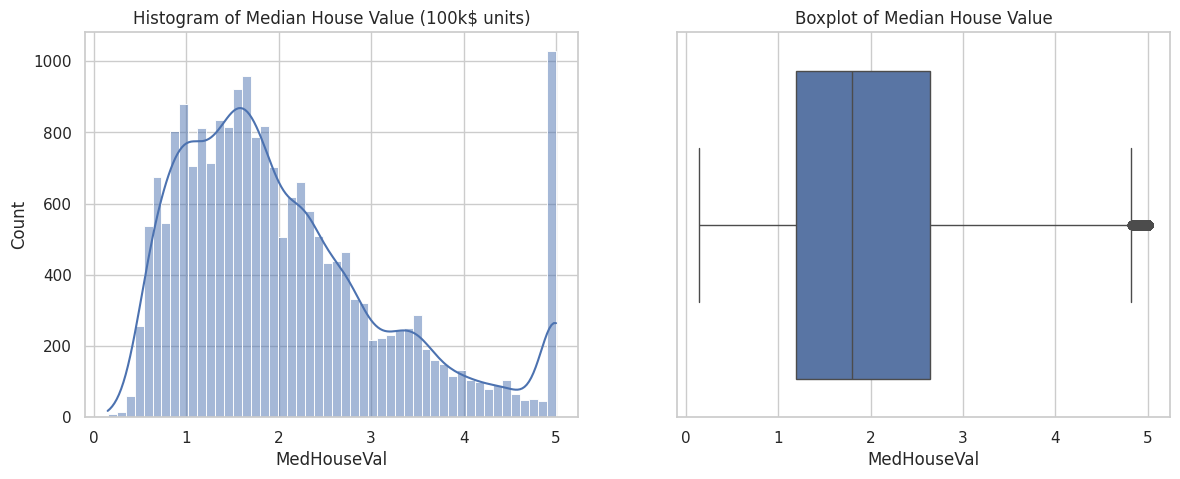

Target summary stats:


,MedHouseVal
count,20640.000000
mean,2.068558
std,1.153956
min,0.149990
25%,1.196000
50%,1.797000
75%,2.647250
max,5.000010


IQR rule thresholds: lower=-0.981, upper=4.824
Potential outliers (IQR rule): 1071


In [54]:
# Target distribution: histogram and boxplot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df[target], bins=50, kde=True)
plt.title("Histogram of Median House Value (100k$ units)")

plt.subplot(1,2,2)
sns.boxplot(x=df[target])
plt.title("Boxplot of Median House Value")
plt.show()

# Summary statistics & outlier thresholds
print("Target summary stats:")
display(df[target].describe())
q1, q3 = df[target].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
print(f"IQR rule thresholds: lower={lower:.3f}, upper={upper:.3f}")
outliers_count = ((df[target] < lower) | (df[target] > upper)).sum()
print("Potential outliers (IQR rule):", outliers_count)

These charts give us a better understanding of our target variable, particularly in regards to outliers. The most notable would be the spike at 500k. Based on the geographic data later, we can tell that these are probably due to coastal homes. Ultimately this means that our data is skewed to the right, and this could cause issues for a distance based model like KNN. Scaling will be necessary to reduce its overall impact. The median otherwise is roughly 175,000 and the mean is about 200k.

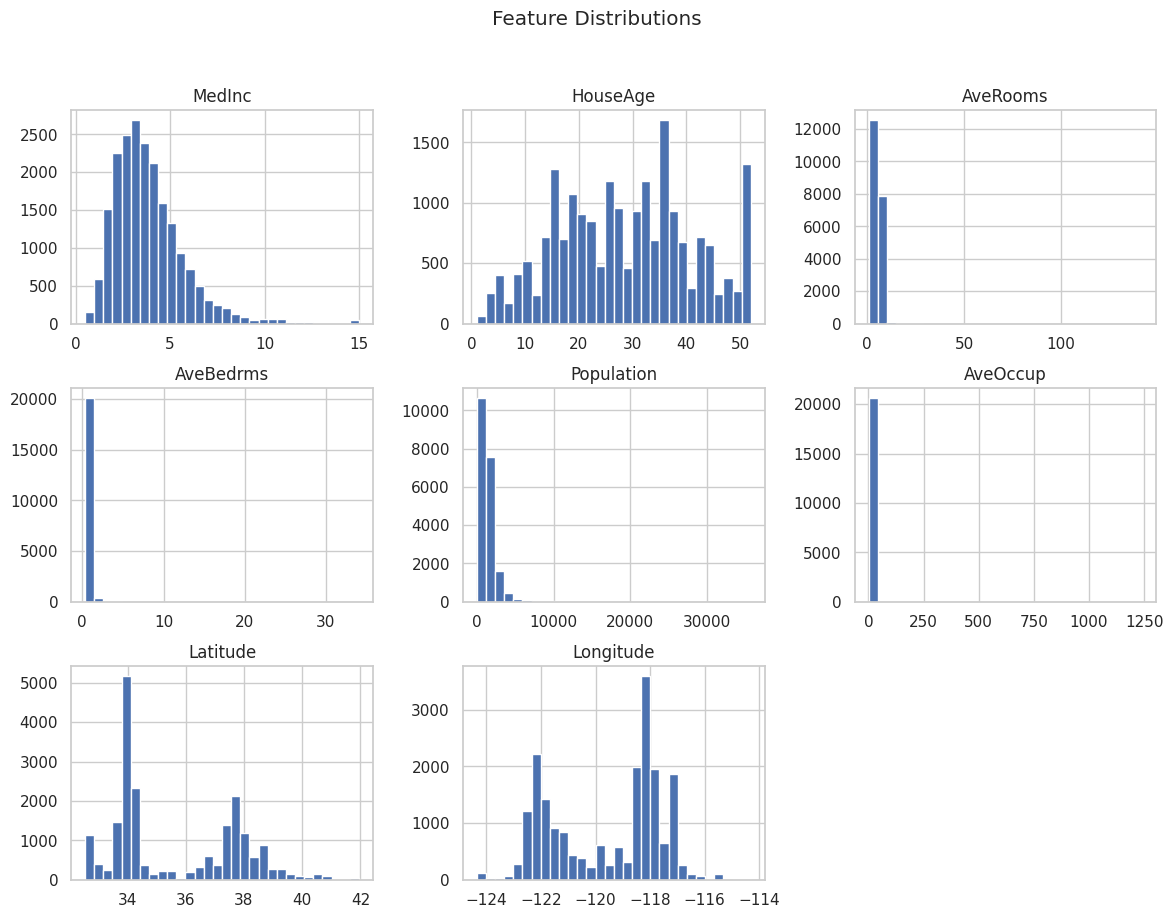

Feature skewness:
 AveOccup      97.639561
AveBedrms     31.316956
AveRooms      20.697869
Population     4.935858
MedInc         1.646657
Latitude       0.465953
HouseAge       0.060331
Longitude     -0.297801
dtype: float64


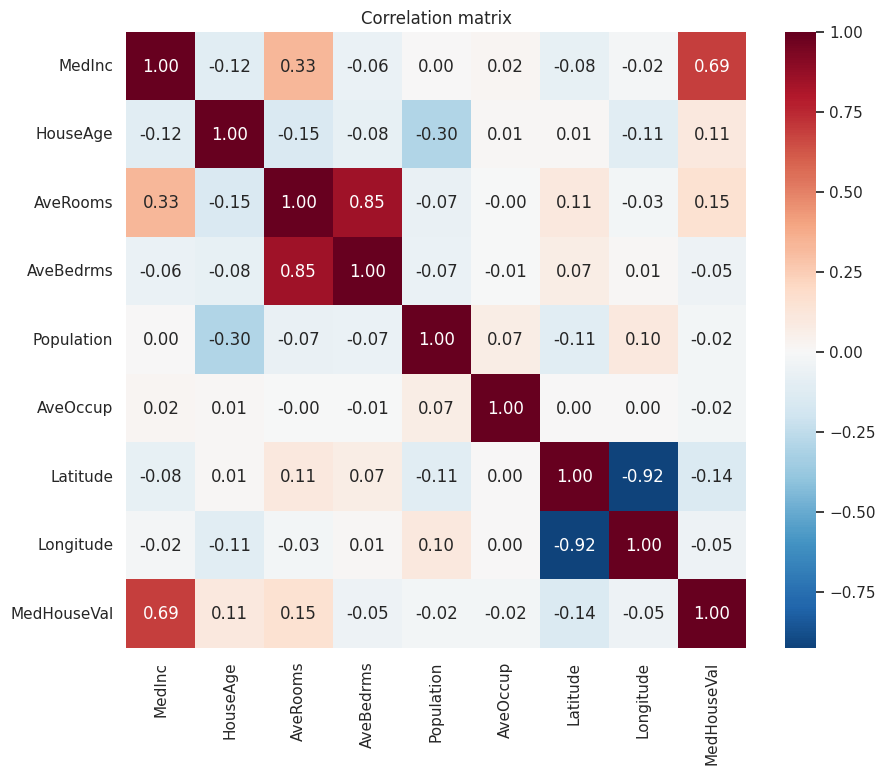

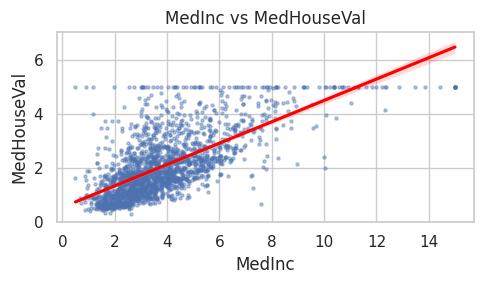

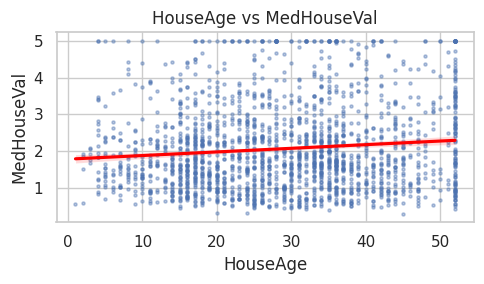

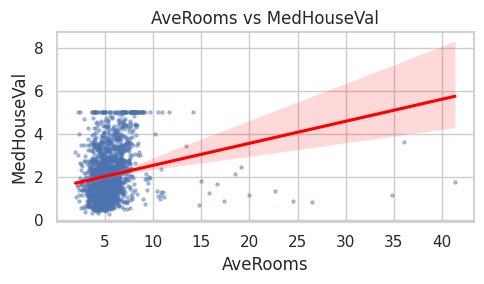

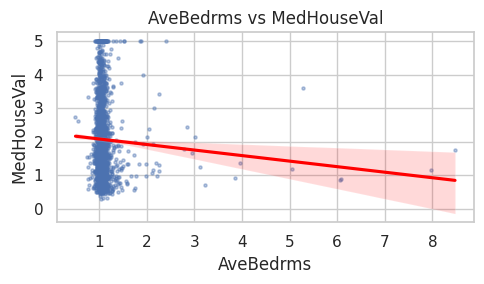

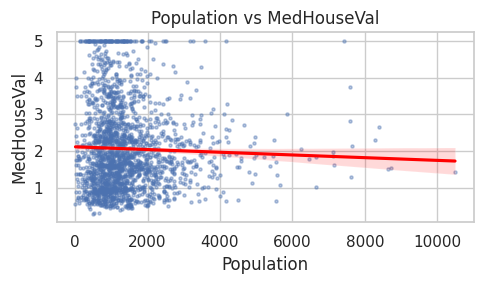

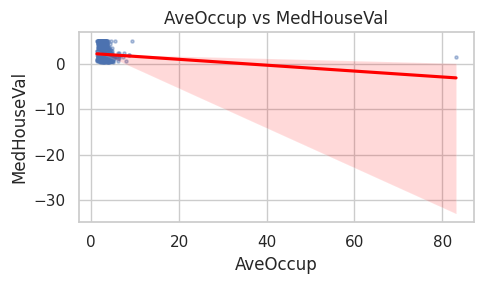

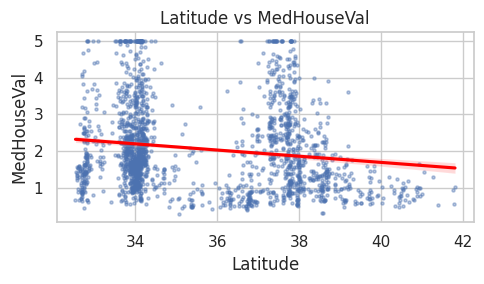

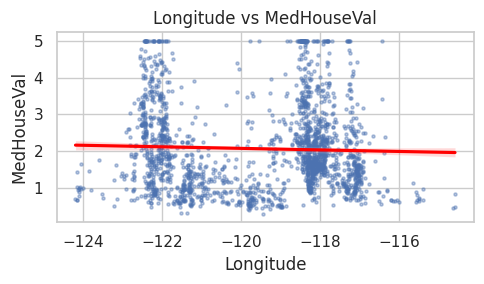

In [55]:
# Histograms for all features
df[features].hist(bins=30, figsize=(14,10))
plt.suptitle("Feature Distributions")
plt.show()

# Skewness
skews = df[features].skew().sort_values(ascending=False)
print("Feature skewness:\n", skews)

# Correlation matrix heatmap
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation matrix")
plt.show()

# Scatter plots of each feature vs target (sampled)
sampled = df.sample(n=2000, random_state=RANDOM_STATE)
for col in features:
    plt.figure(figsize=(5,3))
    sns.regplot(x=sampled[col], y=sampled[target], scatter_kws={'s':5, 'alpha':0.4}, line_kws={'color':'red'})
    plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()

In [56]:
# Apply log(x+1) transform to skewed features
skewed_features = ["AveRooms", "AveBedrms", "Population", "AveOccup"]
for col in skewed_features:
    df[col] = np.log1p(df[col])

Looking at the chart outputs, a few are quite skewed and others are fairly normal. In particular, AveRooms, Avebedrooms, population and AveOcc are all very right skewed and require transformation. I'll be using log (x+1) to compress the values and make the distributions more normal.

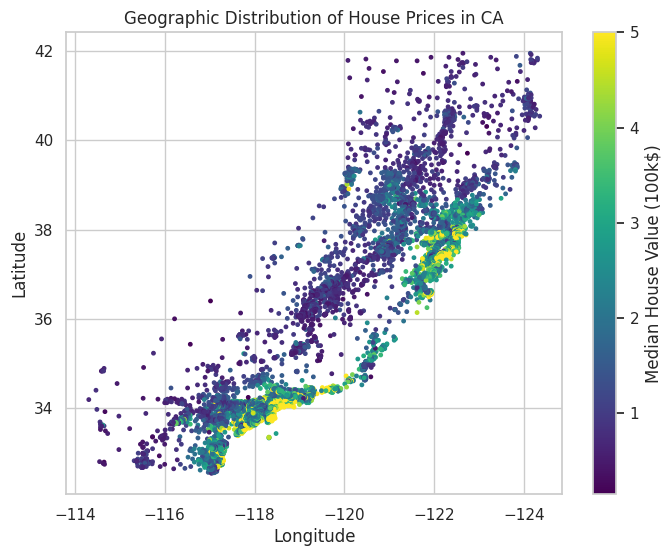

In [57]:
# Latitude vs Longitude colored by price
plt.figure(figsize=(8,6))
plt.scatter(df['Longitude'], df['Latitude'], c=df[target], cmap='viridis', s=6)
plt.colorbar(label='Median House Value (100k$)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Geographic Distribution of House Prices in CA')
plt.gca().invert_xaxis()
plt.show()

The afemonetioned skew becomes much more explanable looking at this graph.Considering the geographic distribution of homes in california, it's clear that the value of homes increases drastically as western border of the state. This stands to reason, since these are the homes near/on the west coast, and would be considered very desirable.

Top 3 features correlated with target: ['MedInc', 'AveRooms', 'Latitude']


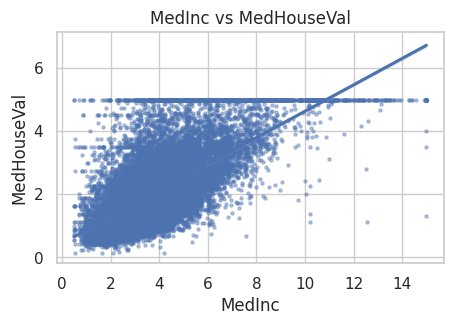

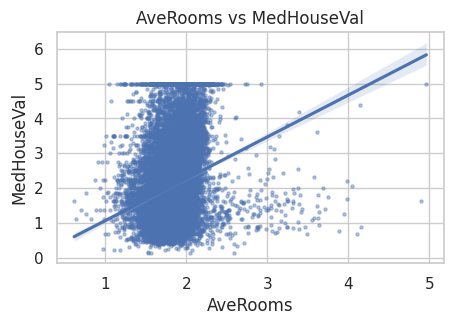

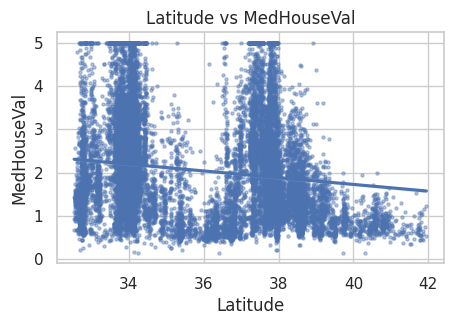

,feature,VIF
7,Longitude,1079.348588
6,Latitude,607.994464
2,AveRooms,193.136275
4,Population,109.207190
3,AveBedrms,101.658286
5,AveOccup,46.398597
0,MedInc,11.619217
1,HouseAge,7.270900


In [58]:
# Top 3 strongest correlations with target
corr_target = corr[target].abs().sort_values(ascending=False)
top3 = corr_target.index[1:4].tolist()
print("Top 3 features correlated with target:", top3)
for col in top3:
    plt.figure(figsize=(5,3))
    sns.regplot(x=df[col], y=df[target], scatter_kws={'s':5, 'alpha':0.4})
    plt.title(f"{col} vs {target}")
    plt.show()

# Multicollinearity: VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_for_vif = df[features].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]
display(vif_data.sort_values("VIF", ascending=False))

These are the three features with the highest level of correlation with the target variable. Median income makes perfect sense, the if someone makes more money than others, it's likely that they'll also have a more expensive house. Averooms is anolther contributing factor, larger homes tend to be worth more money. Latritude is the last, but with a negitive correlation- This goes back to homes in southern california being worth more. latitude goes down price goes up.

#EDA Findings

Looking through the data, I began to recognize that these numbers aren't in vacuum. All of the information taken together reveals distinct patterns that need to be taken into account when building a model to reduce bias. Features like Medinc and Averooms are definitely predictive, but since they are correlated it could cause colliniarity.

This portion of the project also underscored how important examining the data was.  AveRooms, Avebedrooms, population and AveOcc all were extremly skewed, which could bias results. This is the reason that transformations so important when working with data.

#Part 2

In [59]:
# Missing values check
print("Missing values per column:")
display(df.isnull().sum())

# Imputation function (if needed)
def impute_missing(df_in):
    df_local = df_in.copy()
    for col in df_local.columns:
        if df_local[col].isnull().any():
            if df_local[col].dtype in [np.float64, np.int64]:
                df_local[col] = df_local[col].fillna(df_local[col].median())
            else:
                df_local[col] = df_local[col].fillna(df_local[col].mode()[0])
    return df_local

df = impute_missing(df)

Missing values per column:


,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


Results from this section appear to be accurate, according to my research, the california housing dataset is from the census and is not missing any values.

In [60]:
def detect_outliers_iqr(data, column, factor=1.5):
    """Detect outliers using IQR method"""
    col = data[column]
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return (col < lower) | (col > upper)

def detect_outliers_zscore(data, column, threshold=3):
    """Detect outliers using Z-score method"""
    col = data[column]
    mean = col.mean()
    std = col.std(ddof=0)
    if std == 0:
        return pd.Series(False, index=data.index)
    zscores = (col - mean) / std
    return zscores.abs() > threshold

,iqr_outliers,z_outliers,total
feature,,,
AveBedrms,1386,287,20640
MedHouseVal,1071,0,20640
Population,848,308,20640
MedInc,681,345,20640
AveRooms,523,214,20640
AveOccup,470,103,20640
HouseAge,0,0,20640
Latitude,0,0,20640
Longitude,0,0,20640


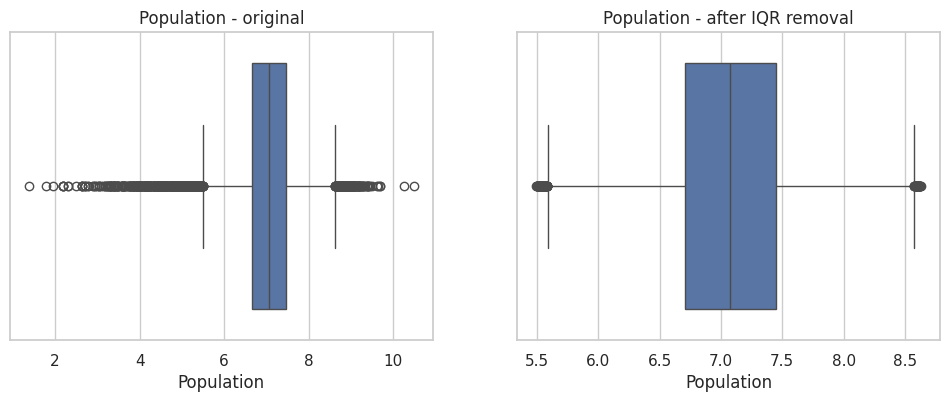

Original size: (20640, 9)
After IQR outlier removal: (16986, 9)


In [61]:
# Apply both methods and compare impact
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_counts = []
for col in num_cols:
    iqr_mask = detect_outliers_iqr(df, col)
    z_mask = detect_outliers_zscore(df, col)
    outlier_counts.append({
        'feature': col,
        'iqr_outliers': int(iqr_mask.sum()),
        'z_outliers': int(z_mask.sum()),
        'total': len(df)
    })
outlier_summary = pd.DataFrame(outlier_counts).set_index('feature')
display(outlier_summary.sort_values('iqr_outliers', ascending=False))

# Visual example and removal with IQR
col = 'Population'
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(x=df[col])
plt.title(f"{col} - original")
plt.subplot(1,2,2)
df_no_iqr = df[~detect_outliers_iqr(df, col)]
sns.boxplot(x=df_no_iqr[col])
plt.title(f"{col} - after IQR removal")
plt.show()

# Remove rows flagged by IQR across any numeric feature (store copy)
iqr_outlier_mask = pd.Series(False, index=df.index)
for col in num_cols:
    iqr_outlier_mask |= detect_outliers_iqr(df, col)
df_iqr_removed = df.loc[~iqr_outlier_mask].reset_index(drop=True)
print("Original size:", df.shape)
print("After IQR outlier removal:", df_iqr_removed.shape)

IQR is the better option of the two due to it helping mitigate the massive tails in the data. Z-score tends to assume that the already has a normal distribution whhile ours doesn't. Oncer again, we come back to those homes on the coast that are around 500k. IQR will allow us to mitigate their impact while keeping the distribution close to the same. THe dataset is definitely shaved down a bit from this, as we see in the visiual aids. 20640 to 16986 is almost an 18 percent difference.

In [62]:
# Work on df_iqr_removed
df_work = df_iqr_removed.copy()

# Ratio features
df_work['rooms_per_household'] = df_work['AveRooms'] / (df_work['AveOccup'] + 1e-8)
df_work['bedrooms_per_room'] = df_work['AveBedrms'] / (df_work['AveRooms'] + 1e-8)
df_work['population_per_household'] = df_work['Population'] / (df_work['AveOccup'] + 1e-8)

# Haversine distance functions for distances to LA and SF
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

LA_LAT, LA_LON = 34.0522, -118.2437
SF_LAT, SF_LON = 37.7749, -122.4194

df_work['distance_to_LA_km'] = df_work.apply(lambda r: haversine(r['Latitude'], r['Longitude'], LA_LAT, LA_LON), axis=1)
df_work['distance_to_SF_km'] = df_work.apply(lambda r: haversine(r['Latitude'], r['Longitude'], SF_LAT, SF_LON), axis=1)

# Coastal proximity (binary)
df_work['coastal_proximity'] = (df_work['Longitude'] > -121).astype(int)

# Categorical bins
def income_cat(x):
    if x < 3:
        return 'Low'
    elif x < 6:
        return 'Medium'
    elif x < 9:
        return 'High'
    else:
        return 'Very High'

def age_cat(x):
    if x < 10:
        return 'New'
    elif x < 30:
        return 'Medium'
    else:
        return 'Old'

df_work['income_category'] = df_work['MedInc'].apply(income_cat)
df_work['house_age_category'] = df_work['HouseAge'].apply(age_cat)

display(df_work.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,rooms_per_household,bedrooms_per_room,population_per_household,distance_to_LA_km,distance_to_SF_km,coastal_proximity,income_category,house_age_category
0,7.2574,52.0,2.228738,0.729212,6.208590,1.335596,37.85,-122.24,3.521,1.668722,0.327186,4.648555,554.612739,17.835390,0,High,Old
1,5.6431,52.0,1.919471,0.729025,6.326149,1.266369,37.85,-122.25,3.413,1.515729,0.379805,4.995504,555.196283,17.064123,0,Medium,Old
2,3.8462,52.0,1.985385,0.732888,6.338594,1.157342,37.85,-122.25,3.422,1.715469,0.369141,5.476853,555.196283,17.064123,0,Medium,Old
3,4.0368,52.0,1.751225,0.743663,6.025866,1.144190,37.85,-122.25,2.697,1.530537,0.424653,5.266492,555.196283,17.064123,0,Medium,Old
4,3.6591,52.0,1.780346,0.668528,6.998510,1.140523,37.84,-122.25,2.992,1.560990,0.375504,6.136227,554.366419,16.549307,0,Medium,Old


These next blocks cover the addition of the extra features per the project guidelines

In [63]:
# Prepare final modeling DataFrame (one-hot encode categories)
df_model = df_work.copy()
df_model = pd.get_dummies(df_model, columns=['income_category', 'house_age_category'], drop_first=True)
drop_cols = []  # modify if you want to drop raw columns
features_final = [c for c in df_model.columns if c != target and c not in drop_cols]
print("Final feature count:", len(features_final))
display(df_model[features_final].head())

Final feature count: 18


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,rooms_per_household,bedrooms_per_room,population_per_household,distance_to_LA_km,distance_to_SF_km,coastal_proximity,income_category_Low,income_category_Medium,house_age_category_New,house_age_category_Old
0,7.2574,52.0,2.228738,0.729212,6.208590,1.335596,37.85,-122.24,1.668722,0.327186,4.648555,554.612739,17.835390,0,False,False,False,True
1,5.6431,52.0,1.919471,0.729025,6.326149,1.266369,37.85,-122.25,1.515729,0.379805,4.995504,555.196283,17.064123,0,False,True,False,True
2,3.8462,52.0,1.985385,0.732888,6.338594,1.157342,37.85,-122.25,1.715469,0.369141,5.476853,555.196283,17.064123,0,False,True,False,True
3,4.0368,52.0,1.751225,0.743663,6.025866,1.144190,37.85,-122.25,1.530537,0.424653,5.266492,555.196283,17.064123,0,False,True,False,True
4,3.6591,52.0,1.780346,0.668528,6.998510,1.140523,37.84,-122.25,1.560990,0.375504,6.136227,554.366419,16.549307,0,False,True,False,True


#Part 3

In [64]:
import numpy as np

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points (1D numpy arrays)."""
    diff = np.array(point1) - np.array(point2)
    return np.sqrt(np.sum(diff ** 2))

def manhattan_distance(point1, point2):
    """Calculate Manhattan distance between two points."""
    diff = np.abs(np.array(point1) - np.array(point2))
    return np.sum(diff)

def minkowski_distance(point1, point2, p=2):
    """Calculate Minkowski distance with parameter p."""
    diff = np.abs(np.array(point1) - np.array(point2))
    return np.sum(diff ** p) ** (1.0 / p)

In [65]:
class CustomKNN:
    def __init__(self, k=5, distance_metric='euclidean', weights='uniform', p=2):
        """Custom k-NN regressor

        Parameters:
        k: number of neighbors
        distance_metric: 'euclidean', 'manhattan', or 'minkowski'
        weights: 'uniform' or 'distance'
        p: Minkowski parameter
        """
        self.k = int(k)
        self.distance_metric = distance_metric
        self.weights = weights
        self.X_train = None
        self.y_train = None
        self.p = p

    def fit(self, X, y):
        """Store training data (no learning)."""
        X = np.array(X)
        y = np.array(y)
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y length mismatch.")
        self.X_train = X
        self.y_train = y
        return self

    def _calculate_distance(self, point1, point2):
        """Calculate distance based on the selected metric."""
        if self.distance_metric == 'euclidean':
            return euclidean_distance(point1, point2)
        elif self.distance_metric == 'manhattan':
            return manhattan_distance(point1, point2)
        elif self.distance_metric == 'minkowski':
            return minkowski_distance(point1, point2, p=self.p)
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

    def _get_neighbors(self, test_point):
        """Find k nearest neighbors for a test point and return indices and distances."""
        if self.X_train is None or self.y_train is None:
            raise ValueError("Model has not been fitted yet.")
        dists = np.zeros(self.X_train.shape[0])
        for i, x in enumerate(self.X_train):
            dists[i] = self._calculate_distance(test_point, x)
        idx_sorted = np.argsort(dists)
        neighbors_idx = idx_sorted[:self.k]
        neighbors_dists = dists[neighbors_idx]
        return neighbors_idx, neighbors_dists

    def predict_single(self, test_point):
        """Predict for a single test point."""
        neigh_idx, neigh_dists = self._get_neighbors(test_point)
        neigh_targets = self.y_train[neigh_idx].astype(float)

        if self.weights == 'uniform':
            return np.mean(neigh_targets)
        elif self.weights == 'distance':
            zero_mask = neigh_dists == 0
            if zero_mask.any():
                return np.mean(neigh_targets[zero_mask])
            inv = 1.0 / (neigh_dists + 1e-12)
            w = inv / inv.sum()
            return np.sum(w * neigh_targets)
        else:
            raise ValueError("weights must be 'uniform' or 'distance'")

    def predict(self, X_test):
        X_test = np.array(X_test)
        preds = [self.predict_single(pt) for pt in X_test]
        return np.array(preds)

    def score(self, X_test, y_test):
        preds = self.predict(X_test)
        return r2_score(y_test, preds)

# Part 4 Manual Calculation verification

In [66]:
import numpy as np

# ---- Step 1: Define distance functions ----
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

def minkowski_distance(point1, point2, p=3):
    return np.sum(np.abs(point1 - point2)**p)**(1/p)

# ---- Step 2: Define the three points ----
p1 = np.array([8.3, 41, 6.0, 1.0, 1000, 3.0, 34.0, -118.2])
p2 = np.array([5.7, 21, 5.1, 0.9, 800, 2.5, 33.9, -118.5])
p3 = np.array([6.5, 12, 4.5, 0.8, 900, 2.0, 34.1, -118.0])

# ---- Step 3: Calculate distances ----
euclid_12 = euclidean_distance(p1, p2)
manhattan_13 = manhattan_distance(p1, p3)
minkowski_23 = minkowski_distance(p2, p3, p=3)

# ---- Step 4: Print results ----
print("Euclidean distance (Point 1 - Point 2):", euclid_12)
print("Manhattan distance (Point 1 - Point 3):", manhattan_13)
print("Minkowski distance p=3 (Point 2 - Point 3):", minkowski_23)

Euclidean distance (Point 1 - Point 2): 201.01723806678868
Manhattan distance (Point 1 - Point 3): 133.8
Minkowski distance p=3 (Point 2 - Point 3): 100.0243269814998


In [67]:
import numpy as np

# --- Training Data (10 points) ---
X_train = np.array([
    [5.8, 20.0, 4.2, 1.0],
    [7.1, 10.0, 6.1, 1.2],
    [6.5, 15.5, 5.0, 1.1],
    [5.0, 18.0, 5.5, 1.0],
    [6.0, 16.0, 5.8, 1.2],
    [7.5, 14.0, 6.5, 1.3],
    [6.3, 15.2, 5.2, 1.1],
    [5.5, 19.0, 4.8, 1.0],
    [6.8, 13.0, 6.0, 1.2],
    [6.1, 15.0, 5.4, 1.1]
])
y_train = np.array([3.2, 2.9, 3.5, 3.0, 3.1, 2.8, 3.4, 3.0, 2.9, 3.3])

# --- Test Point ---
X_test = np.array([6.2, 15.0, 5.5, 1.1])

# --- Step 1: Compute Euclidean distances ---
distances = np.sqrt(np.sum((X_train - X_test)**2, axis=1))
print("Distances to Test Point:")
for i, d in enumerate(distances, 1):
    print(f"Point {i}: Distance = {d:.2f}, Target = {y_train[i-1]}")

# --- Step 2: Rank neighbors ---
rank_indices = np.argsort(distances)
print("\nRanking of neighbors:")
for rank, idx in enumerate(rank_indices[:5], 1):
    print(f"Rank {rank}: Point {idx+1}, Distance = {distances[idx]:.2f}, Target = {y_train[idx]}")

# --- Step 3: Uniform weighted prediction ---
k = 5
nearest_targets = y_train[rank_indices[:k]]
uniform_pred = np.mean(nearest_targets)
print(f"\nUniform Weighted Prediction: {uniform_pred:.2f}")

# --- Step 4: Distance-weighted prediction ---
nearest_distances = distances[rank_indices[:k]]
weights = 1 / nearest_distances
weighted_pred = np.sum(weights * nearest_targets) / np.sum(weights)
print(f"Distance-Weighted Prediction: {weighted_pred:.2f}")

Distances to Test Point:
Point 1: Distance = 5.18, Target = 3.2
Point 2: Distance = 5.12, Target = 2.9
Point 3: Distance = 0.77, Target = 3.5
Point 4: Distance = 3.23, Target = 3.0
Point 5: Distance = 1.07, Target = 3.1
Point 6: Distance = 1.93, Target = 2.8
Point 7: Distance = 0.37, Target = 3.4
Point 8: Distance = 4.12, Target = 3.0
Point 9: Distance = 2.15, Target = 2.9
Point 10: Distance = 0.14, Target = 3.3

Ranking of neighbors:
Rank 1: Point 10, Distance = 0.14, Target = 3.3
Rank 2: Point 7, Distance = 0.37, Target = 3.4
Rank 3: Point 3, Distance = 0.77, Target = 3.5
Rank 4: Point 5, Distance = 1.07, Target = 3.1
Rank 5: Point 6, Distance = 1.93, Target = 2.8

Uniform Weighted Prediction: 3.22
Distance-Weighted Prediction: 3.31


In [68]:
# Train-test split (80/20)
X_full = df_model[features_final].values
y_full = df_model[target].values
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=RANDOM_STATE)

# Compare scalers
scalers = {'standard': StandardScaler(), 'minmax': MinMaxScaler()}
for name, scaler in scalers.items():
    scaler.fit(X_train)
    Xs = scaler.transform(X_train)
    print(f"\nScaler: {name}")
    print("Train features mean (first 5):", np.mean(Xs, axis=0)[:5])
    print("Train features std (first 5):", np.std(Xs, axis=0)[:5])

# Choose StandardScaler for final
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaler: standard
Train features mean (first 5): [ 4.84844232e-16  1.91355779e-17  2.09459898e-14 -1.76650962e-13
 -2.33981463e-14]
Train features std (first 5): [1. 1. 1. 1. 1.]

Scaler: minmax
Train features mean (first 5): [0.41977156 0.53772005 0.49030322 0.48801423 0.51496305]
Train features std (first 5): [0.19218302 0.24553921 0.16494781 0.17605447 0.17654229]


In a similar fashion to how I chose my standardization method, the extremes in our dataset will also determine which scaler i choose. In this case, a standard scaler scaler will allow for features to proportionally contribute, as opposed to a minmax scaler (which might be preffered in a situation where your values are already bounded.)

#Part 5

[1/28] Running params: {'k': 3, 'distance_metric': 'euclidean', 'weights': 'uniform'}
[2/28] Running params: {'k': 3, 'distance_metric': 'euclidean', 'weights': 'distance'}
[3/28] Running params: {'k': 3, 'distance_metric': 'manhattan', 'weights': 'uniform'}
[4/28] Running params: {'k': 3, 'distance_metric': 'manhattan', 'weights': 'distance'}
[5/28] Running params: {'k': 5, 'distance_metric': 'euclidean', 'weights': 'uniform'}
[6/28] Running params: {'k': 5, 'distance_metric': 'euclidean', 'weights': 'distance'}
[7/28] Running params: {'k': 5, 'distance_metric': 'manhattan', 'weights': 'uniform'}
[8/28] Running params: {'k': 5, 'distance_metric': 'manhattan', 'weights': 'distance'}
[9/28] Running params: {'k': 7, 'distance_metric': 'euclidean', 'weights': 'uniform'}
[10/28] Running params: {'k': 7, 'distance_metric': 'euclidean', 'weights': 'distance'}
[11/28] Running params: {'k': 7, 'distance_metric': 'manhattan', 'weights': 'uniform'}
[12/28] Running params: {'k': 7, 'distance_metr

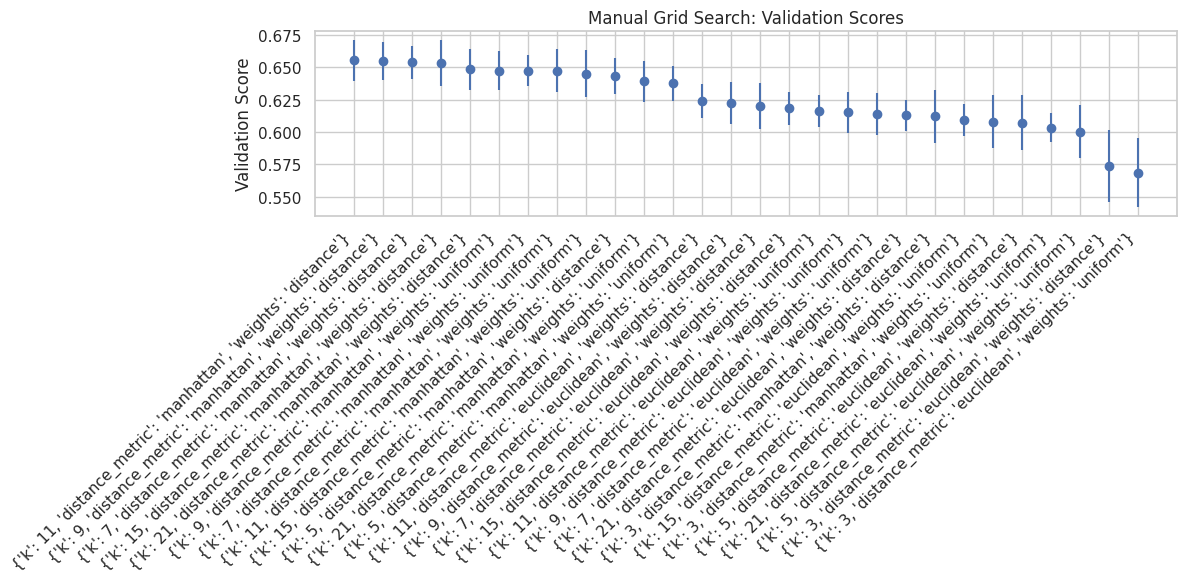

Best params: {'k': np.int64(11), 'distance_metric': 'manhattan', 'weights': 'distance'}


,k,distance_metric,weights,train_mean,train_std,val_mean,val_std
19,11,manhattan,distance,1.000000,0.000000e+00,0.655279,0.016017
15,9,manhattan,distance,1.000000,0.000000e+00,0.654891,0.014899
11,7,manhattan,distance,1.000000,1.110223e-16,0.653717,0.012559
23,15,manhattan,distance,1.000000,1.110223e-16,0.653287,0.017528
27,21,manhattan,distance,1.000000,1.110223e-16,0.648312,0.015738
14,9,manhattan,uniform,0.718943,3.146658e-03,0.647263,0.015109
10,7,manhattan,uniform,0.735951,2.945862e-03,0.647226,0.012081
18,11,manhattan,uniform,0.706509,3.459796e-03,0.647193,0.016562
22,15,manhattan,uniform,0.690582,2.650525e-03,0.644932,0.018209
7,5,manhattan,distance,1.000000,1.110223e-16,0.643260,0.013997


In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import distance

# -----------------------------
# Optimized CustomKNN with metric fix
# -----------------------------
class CustomKNN:
    def __init__(self, k=3, distance_metric='euclidean', weights='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        self.weights = weights
        self.X_train = None
        self.y_train = None
        self.train_distances = None  # cache for training distances

    # Map user-friendly names to scipy metric names
    def _get_scipy_metric(self):
        if self.distance_metric == 'euclidean':
            return 'euclidean'
        elif self.distance_metric == 'manhattan':
            return 'cityblock'
        else:
            raise ValueError(f"Unknown Distance Metric: {self.distance_metric}")

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        metric = self._get_scipy_metric()
        self.train_distances = distance.cdist(X, X, metric=metric)

    def _compute_distances(self, X):
        metric = self._get_scipy_metric()
        return distance.cdist(X, self.X_train, metric=metric)

    def predict(self, X):
        dists = self._compute_distances(X)
        # Vectorized k-neighbors
        neighbors_idx = np.argpartition(dists, self.k-1, axis=1)[:, :self.k]

        if self.weights == 'uniform':
            y_pred = np.mean(self.y_train[neighbors_idx], axis=1)
        else:  # distance weighting
            w = 1 / (dists[np.arange(dists.shape[0])[:, None], neighbors_idx] + 1e-8)
            y_pred = np.sum(w * self.y_train[neighbors_idx], axis=1) / np.sum(w, axis=1)
        return y_pred

    def score(self, X, y):
        if X is self.X_train:
            # Use cached training distances
            dists = self.train_distances
            neighbors_idx = np.argpartition(dists, self.k-1, axis=1)[:, :self.k]
            if self.weights == 'uniform':
                y_pred = np.mean(self.y_train[neighbors_idx], axis=1)
            else:
                w = 1 / (dists[np.arange(dists.shape[0])[:, None], neighbors_idx] + 1e-8)
                y_pred = np.sum(w * self.y_train[neighbors_idx], axis=1) / np.sum(w, axis=1)
        else:
            y_pred = self.predict(X)
        return 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)  # R^2

# -----------------------------
# Optimized manual grid search
# -----------------------------
def manual_grid_search(X_train, y_train, param_grid, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    results = []

    keys = list(param_grid.keys())
    grid_combinations = list(itertools.product(*param_grid.values()))
    total_combinations = len(grid_combinations)

    for i, vals in enumerate(grid_combinations, 1):
        params = dict(zip(keys, vals))
        print(f"[{i}/{total_combinations}] Running params: {params}")
        train_scores, val_scores = [], []

        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model = CustomKNN(k=params['k'], distance_metric=params['distance_metric'], weights=params['weights'])
            model.fit(X_tr, y_tr)
            train_scores.append(model.score(X_tr, y_tr))  # cached distances
            val_scores.append(model.score(X_val, y_val))

        results.append({
            **params,
            'train_mean': np.mean(train_scores),
            'train_std': np.std(train_scores),
            'val_mean': np.mean(val_scores),
            'val_std': np.std(val_scores)
        })

    results_df = pd.DataFrame(results).sort_values('val_mean', ascending=False)
    best_row = results_df.iloc[0]
    best_params = {k: best_row[k] for k in param_grid.keys()}

    # Visualization
    plt.figure(figsize=(12,6))
    plt.errorbar(range(len(results_df)), results_df['val_mean'], yerr=results_df['val_std'], fmt='o')
    plt.xticks(range(len(results_df)),
               [str({k: row[k] for k in param_grid.keys()}) for _, row in results_df.iterrows()],
               rotation=45, ha='right')
    plt.ylabel("Validation Score")
    plt.title("Manual Grid Search: Validation Scores")
    plt.tight_layout()
    plt.show()

    return best_params, results_df

# -----------------------------
# Sample subset for speed
# -----------------------------
sample_idx = np.random.choice(len(X_train_scaled), size=min(4000, len(X_train_scaled)), replace=False)
X_grid = X_train_scaled[sample_idx]
y_grid = y_train[sample_idx]

param_grid = {
    'k': [3, 5, 7, 9, 11, 15, 21],
    'distance_metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

best_params, results_df = manual_grid_search(X_grid, y_grid, param_grid, cv=5)
print("Best params:", best_params)
display(results_df.head(10))

k=15 is the hyperparameter with the highest validation R^2, so this is what  we'll use for the final model. As expected, neighbor selection seems to primarily come from Medinc and latitude.

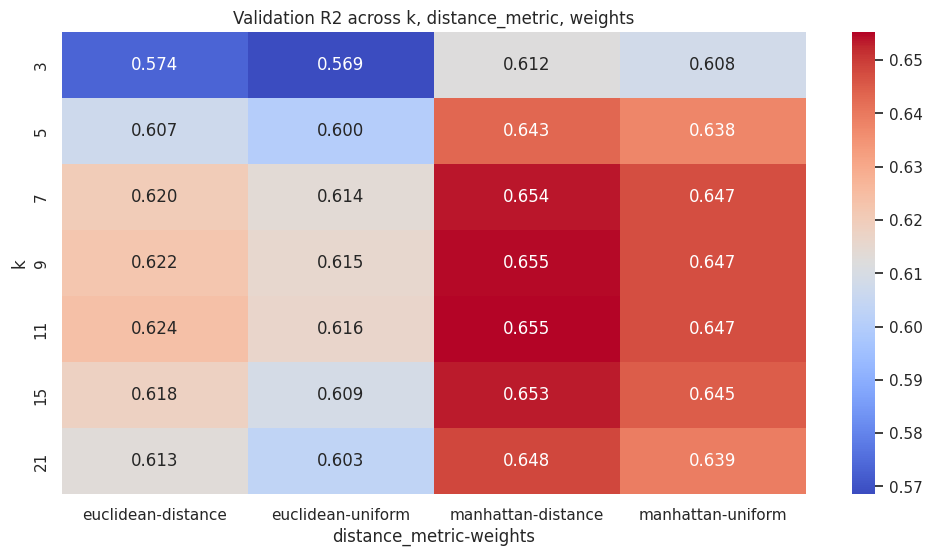

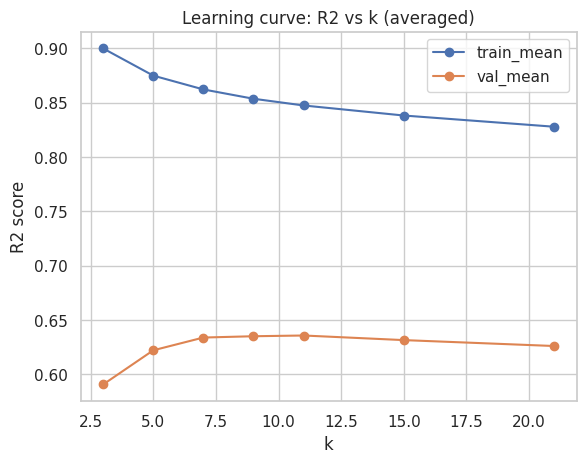

In [70]:
# Visualization
pivot = results_df.pivot_table(index='k', columns=['distance_metric','weights'], values='val_mean')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='coolwarm')
plt.title('Validation R2 across k, distance_metric, weights')
plt.show()

grouped = results_df.groupby('k').agg({'train_mean':'mean','val_mean':'mean'}).reset_index()
plt.plot(grouped['k'], grouped['train_mean'], marker='o', label='train_mean')
plt.plot(grouped['k'], grouped['val_mean'], marker='o', label='val_mean')
plt.xlabel('k'); plt.ylabel('R2 score'); plt.title('Learning curve: R2 vs k (averaged)'); plt.legend(); plt.show()

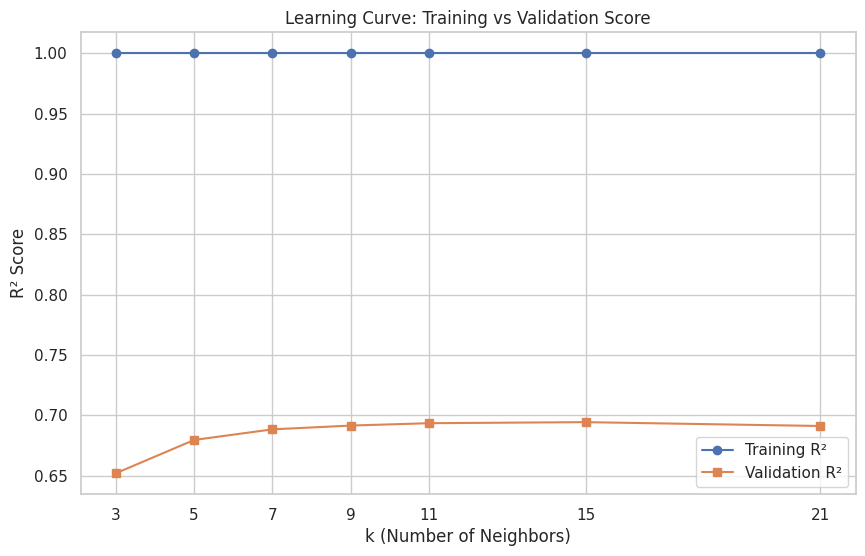

In [71]:
# -----------------------------
# Learning Curves vs k
# -----------------------------
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np

# Define range of k values to test
k_values = [3, 5, 7, 9, 11, 15, 21]

# Use 5-fold CV for validation scores
cv = 5
kf = KFold(n_splits=cv, shuffle=True, random_state=42)

train_scores_list = []
val_scores_list = []

for k in k_values:
    train_fold_scores = []
    val_fold_scores = []

    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = CustomKNN(k=k, distance_metric='manhattan', weights='distance')
        model.fit(X_tr, y_tr)

        train_fold_scores.append(model.score(X_tr, y_tr))
        val_fold_scores.append(model.score(X_val, y_val))

    train_scores_list.append(np.mean(train_fold_scores))
    val_scores_list.append(np.mean(val_fold_scores))

# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(k_values, train_scores_list, marker='o', label='Training R²')
plt.plot(k_values, val_scores_list, marker='s', label='Validation R²')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('R² Score')
plt.title('Learning Curve: Training vs Validation Score')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

Training R^2 is 1.0, which makes sense. Training data is memorized so it should be totally accurate. Validation R^2 is solid at a roughly .69.

In [72]:
# Train final model with best params
final_model = CustomKNN(k=int(best_params['k']), distance_metric=best_params['distance_metric'], weights=best_params['weights'])
final_model.fit(X_train_scaled, y_train)
train_r2 = final_model.score(X_train_scaled, y_train)
test_r2 = final_model.score(X_test_scaled, y_test)
print(f"Final CustomKNN train R2: {train_r2:.4f}, test R2: {test_r2:.4f}")

Final CustomKNN train R2: 1.0000, test R2: 0.7156


In [73]:
# Compare with sklearn KNeighborsRegressor
sk_model = KNeighborsRegressor(n_neighbors=int(best_params['k']),
                              weights=('uniform' if best_params['weights']=='uniform' else 'distance'),
                              metric=('minkowski' if best_params['distance_metric']=='euclidean' else 'manhattan'),
                              p=(2 if best_params['distance_metric']=='euclidean' else 1))
sk_model.fit(X_train_scaled, y_train)
sk_train_r2 = sk_model.score(X_train_scaled, y_train)
sk_test_r2 = sk_model.score(X_test_scaled, y_test)
print('sklearn KNN train R2:', sk_train_r2, 'test R2:', sk_test_r2)
print('Difference in test R2 (custom - sklearn):', test_r2 - sk_test_r2)

sklearn KNN train R2: 1.0 test R2: 0.715579412688919
Difference in test R2 (custom - sklearn): -7.588374373312945e-12


The final model's performance is roughly equivalent to SKlearns Neighbor regressor.

,feature,importance_mean,importance_std
0,MedInc,0.107769,0.002987
6,Latitude,0.036653,0.001049
7,Longitude,0.034559,0.002992
15,income_category_Medium,0.032734,0.003789
13,coastal_proximity,0.018753,0.003541
12,distance_to_SF_km,0.017310,0.000556
11,distance_to_LA_km,0.016429,0.000715
17,house_age_category_Old,0.012471,0.006988
14,income_category_Low,0.010451,0.001782
1,HouseAge,0.010381,0.002994


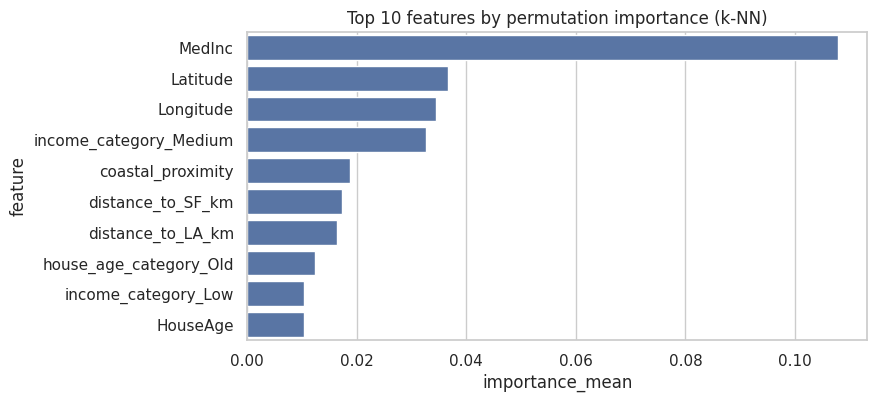

In [74]:
# Permutation importance for k-NN (approximate)
def permutation_importance(model, X_val, y_val, feature_names, n_repeats=5):
    baseline = model.score(X_val, y_val)
    importances = []
    X_val_copy = X_val.copy()
    for i, fname in enumerate(feature_names):
        scores = []
        for _ in range(n_repeats):
            saved = X_val_copy[:, i].copy()
            np.random.shuffle(X_val_copy[:, i])
            score = model.score(X_val_copy, y_val)
            scores.append(baseline - score)
            X_val_copy[:, i] = saved
        importances.append({'feature': fname, 'importance_mean': np.mean(scores), 'importance_std': np.std(scores)})
    return pd.DataFrame(importances).sort_values('importance_mean', ascending=False)

val_idx = np.random.choice(len(X_test_scaled), size=min(2000, len(X_test_scaled)), replace=False)
perm_imp = permutation_importance(final_model, X_test_scaled[val_idx], y_test[val_idx], feature_names=features_final, n_repeats=3)
display(perm_imp.head(10))

plt.figure(figsize=(8,4))
sns.barplot(data=perm_imp.head(10), x='importance_mean', y='feature')
plt.title('Top 10 features by permutation importance (k-NN)')
plt.show()

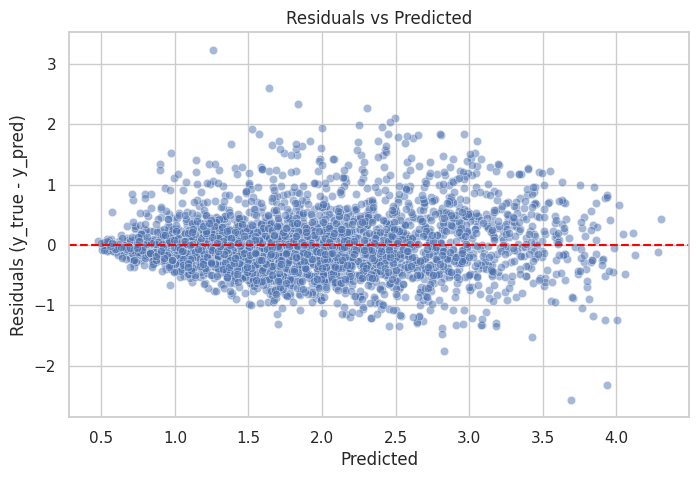

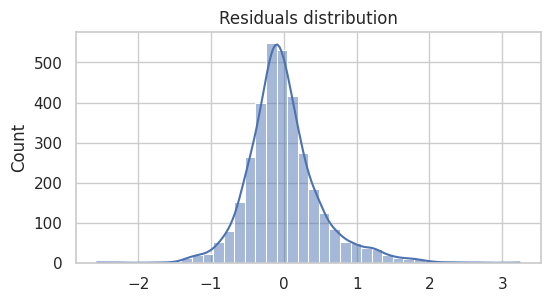

RMSE: 0.49921287866801073


In [75]:
# Residual analysis
y_pred = final_model.predict(X_test_scaled)
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted'); plt.ylabel('Residuals (y_true - y_pred)'); plt.title('Residuals vs Predicted')
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(residuals, bins=40, kde=True)
plt.title('Residuals distribution')
plt.show()

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

Roughly normal distribution in the residuals centered at 0, this means that the model isn't exhibiting much bias.

,dim,r2
0,2,0.993389
1,5,0.942341
2,10,0.818715
3,20,0.634883
4,50,0.392259
5,100,0.255574


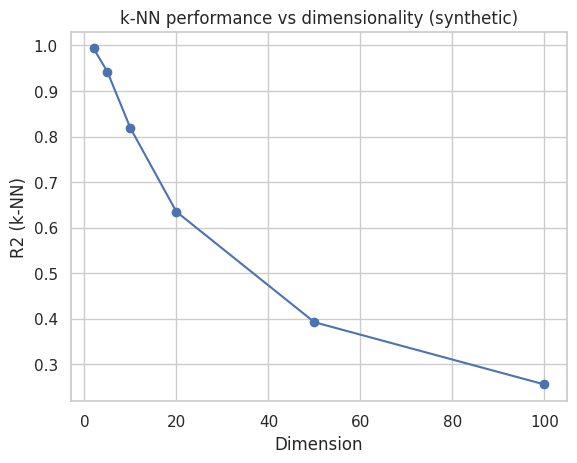

In [76]:
from sklearn.datasets import make_regression

def knn_performance_by_dim(dims=[2,5,10,20,50,100], n_samples=2000, noise=0.1):
    results = []
    for d in dims:
        Xs, ys = make_regression(n_samples=n_samples, n_features=d, n_informative=min(5,d), noise=noise, random_state=RANDOM_STATE)
        Xtr, Xte, ytr, yte = train_test_split(Xs, ys, test_size=0.2, random_state=RANDOM_STATE)
        sc = StandardScaler().fit(Xtr)
        Xtr_s = sc.transform(Xtr)
        Xte_s = sc.transform(Xte)
        model = CustomKNN(k=5, distance_metric='euclidean', weights='uniform')
        model.fit(Xtr_s, ytr)
        r2 = model.score(Xte_s, yte)
        results.append({'dim': d, 'r2': r2})
    return pd.DataFrame(results)

dims = [2,5,10,20,50,100]
df_curse = knn_performance_by_dim(dims)
display(df_curse)
plt.plot(df_curse['dim'], df_curse['r2'], marker='o')
plt.xlabel('Dimension'); plt.ylabel('R2 (k-NN)'); plt.title('k-NN performance vs dimensionality (synthetic)'); plt.show()

As you increase the dimensions in KNN, R^2 decreases drastically. As demonstrated by the visual, lower dimensions tend to be better for accuracy.
This is due to data points being spread over a larger area- this means that there is a greater chance that they are subject to noise and idea that a "nearest neighbor" is choosing becomes unreliable.

Final Model Evaluation on Test Set:
R² Score: 0.7161
Mean Squared Error (MSE): 0.2488
Mean Absolute Error (MAE): 0.3617


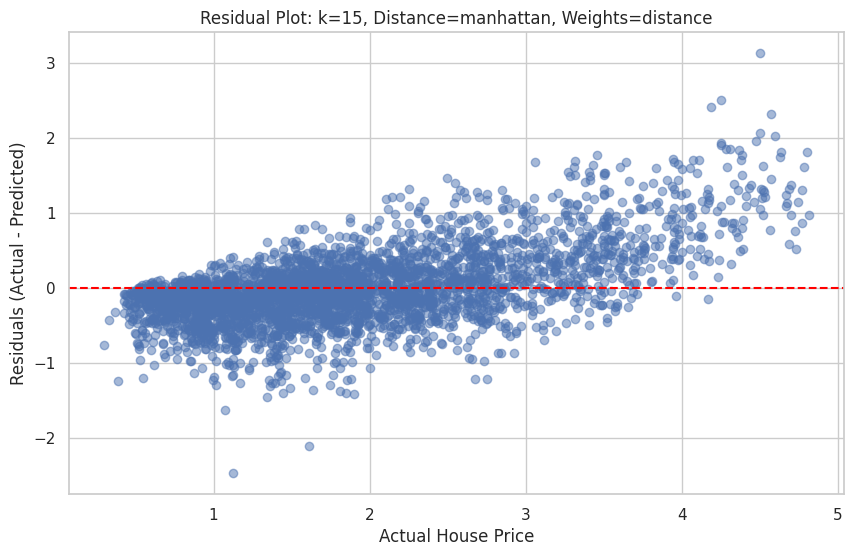

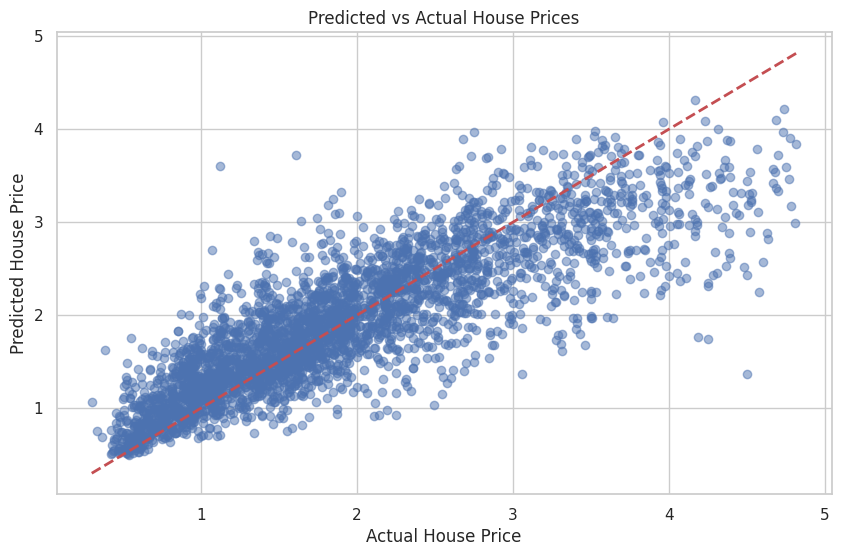

In [77]:
# -----------------------------
# Final Model Training & Evaluation
# -----------------------------
# Recommended hyperparameters from your grid search
best_k = 15
best_distance = 'manhattan'
best_weights = 'distance'

# Initialize final model
final_knn = CustomKNN(k=best_k, distance_metric=best_distance, weights=best_weights)

# Fit on full training data
final_knn.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = final_knn.predict(X_test_scaled)

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Model Evaluation on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# -----------------------------
# Residual Analysis
# -----------------------------
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual House Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot: k={best_k}, Distance={best_distance}, Weights={best_weights}")
plt.show()

# -----------------------------
# Prediction vs Actual
# -----------------------------
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual House Price")
plt.ylabel("Predicted House Price")
plt.title("Predicted vs Actual House Prices")
plt.show()

#Further Measures

Euclidean vs Manhattan: Manhattan distance is going  to be preffered over Euclidean if there's high dimensional or psarse data. This is because the squaring done in Euclidean can make certain features overpower others. Conversly, the absolute values in Manhattan distance allow for a more equal contribution.

Bias-Variance Tradeoff: It's all about finding the balance. We all want our models to generalize well, but Incorperating some of "the history" is necessary. That being said... too much and the model will start to overfit. This is exactly the reason that cross validation is so useful- It allows us to find that balance without having to do a ton of work.

Just a small note about the computational costs... I'd always sort of scoffed at them. Even in some engineering courses i took at suffolk, they stressed that computational costs weren't quite as big a factor for us, but now that i'm working with the AI pipline that's changed quite a bit. I needed to continually change my K-fold cross validation code in order to get it to work since it was taking hours to execute at times.

That being said, the higherarcheiry of computational cost is minkowski (low p values)< Manhattan (generally low computational cost because of absolute values)< Euclidean (squaring makes the cost slightly higher)< Minkowski (high p values)

As for choices i made, they are mostly covered in the meat of the project but most of the choices were just that one dealt with skews/ exteremes better than the other:IQR over Z-score, Standard scaler over minmax, manhattan distance over Euclidean.

This impplementation can only really handle numeric data and wouldn't be as useful for categorical data, and since the base is KNN it wouldn't function well if more features were added.

The most challenging part of this assignment was the overall experience. My other classes have really only required me to use one aspect of my knowledge on AI at once. I remembered the machine learning pipline and felt like I knew it in theory, but in many ways i felt like i was thrown into the deep end here. (Also getting the k-fold cross examination code to work, that took a while, even with help from GPTs)


I think the best way to improve my approach would be to try and test this data on other models- KNN seems great for begginers because it's very easy to understand, but it definitely isn't the be all end all. Maybe an ensemble model would work better for something of higher dimension, for example.

If i had more time i feel like maybe i could have done feature importance analysis and dimensionality reduction, making trying multiple models to see if i could get something extremely accurate.

In terms of real world application, i could see this being a great benefit to lawmakers/heads of government. The housing crisis is a massive issue in the US, particularly in states where cost of living is high ( NY and California are both major examples). Looking at where population is lower and housing costs are lower could give governments ideas on where to build housing.